# Procesamiento del Lenguaje Natural - TP2
## Tecnicatura universitaria en Inteligencia Aritficial
### Julia Sumiacher S-57932

# Instalar dependencias

In [24]:
# Instalar dependencias necesarias
!pip install -U langchain-community openai langchain langchain-openai chromadb PyPDF2 sentence-transformers requests beautifulsoup4 transformers huggingface_hub selenium webdriver-manager --upgrade py2neo

# Descargar e instalar Google Chrome
!wget -q -O google-chrome-stable_current_amd64.deb https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
!dpkg -i google-chrome-stable_current_amd64.deb || apt-get -fy install

# Instalar ChromeDriver de acuerdo con la versión de Chrome
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

# Configurar Chrome para trabajar en Colab
options = webdriver.ChromeOptions()
options.add_argument('--headless')  # Ejecutar sin interfaz gráfica
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

# Descargar e instalar ChromeDriver automáticamente
!apt-get update -y && apt-get install -yqq unzip
!rm -rf /tmp/chromedriver.zip
chromedriver_path = ChromeDriverManager().install()
print(f"ChromeDriver instalado en: {chromedriver_path}")

# Prueba para verificar que todo esté correctamente configurado
try:
    driver = webdriver.Chrome(service=Service(chromedriver_path), options=options)
    driver.get("https://www.google.com")
    print("Título de la página:", driver.title)
    driver.quit()
except Exception as e:
    print("Error en la configuración de Selenium:", str(e))



  Using cached transformers-4.47.1-py3-none-any.whl.metadata (44 kB)
INFO: pip is looking at multiple versions of transformers to determine which version is compatible with other requirements. This could take a while.
  Using cached transformers-4.47.0-py3-none-any.whl.metadata (43 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.2/177.2 kB 6.5 MB/s eta 0:00:00
(Reading database ... 123790 files and directories currently installed.)
Preparing to unpack google-chrome-stable_current_amd64.deb ...
Unpacking google-chrome-stable (131.0.6778.139-1) over (131.0.6778.139-1) ...
Setting up google-chrome-stable (131.0.6778.139-1) ...
Processing triggers for man-db (2.10.2-1) ...
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:5 http://s

# Instalar librerías

In [52]:
import chromadb
import re
import os
import time
import math
import requests
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from openai import OpenAI
from openai import OpenAIError
from sklearn.svm import SVC
from bs4 import BeautifulSoup
from sentence_transformers import SentenceTransformer, CrossEncoder
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
from transformers import pipeline
from chromadb import Client
from chromadb.utils import embedding_functions
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from py2neo import Graph
from sklearn.metrics.pairwise import cosine_similarity

# Bases de datos

## Base de datos vectorial

In [20]:
# Configuración Global
THREAD_ID = "2687942"
XML_ENDPOINT = f"https://boardgamegeek.com/xmlapi2/thread?id={THREAD_ID}"
CHROMADB_DIR = "./chromadb_reviews"

##########################################
# Función 1: Extraer Comentarios del XML
##########################################
def fetch_comments(url):
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Error al acceder al endpoint: {response.status_code}")

    root = ET.fromstring(response.content)
    comments = []
    for article in root.findall(".//article"):
        username = article.get("username", "Desconocido")
        postdate = article.get("postdate", "Sin fecha")
        message = article.find("body").text if article.find("body") is not None else ""
        comments.append({
            "username": username,
            "postdate": postdate,
            "message": message.strip()
        })
    return comments

##########################################
# Función 2: Limpiar el Texto
##########################################
def clean_text(text):
    """Limpia el texto removiendo caracteres especiales, espacios extras y saltos de línea."""
    text = re.sub(r'\s+', ' ', text)  # Remueve espacios múltiples
    text = re.sub(r'[^\w\s.,!?]', '', text)  # Remueve caracteres especiales (excepto puntuaciones básicas)
    return text.strip()

##########################################
# Función 3: Dividir Texto en Chunks
##########################################
def split_texts(comments, chunk_size=500, chunk_overlap=50):
    """Divide los comentarios en chunks usando LangChain RecursiveCharacterTextSplitter."""
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    all_chunks = []

    for comment in comments:
        clean_message = clean_text(comment["message"])
        chunks = text_splitter.split_text(clean_message)
        for chunk in chunks:
            all_chunks.append({
                "content": chunk,
                "username": comment["username"],
                "postdate": comment["postdate"]
            })
    return all_chunks

##########################################
# Función 4: Generar Embeddings con Sentence Transformers
##########################################
def generate_embeddings(texts):
    """Genera embeddings usando Sentence Transformers."""
    print("Generando embeddings con Sentence Transformers...")
    model = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings = model.encode(texts, show_progress_bar=True)
    return embeddings

##########################################
# Función 5: Almacenar Embeddings en ChromaDB
##########################################
def store_in_chromadb(chunks, embeddings, db_dir):
    """Almacena embeddings y metadatos en ChromaDB."""
    print("Creando base de datos ChromaDB...")
    client = chromadb.PersistentClient(path=db_dir)
    collection = client.get_or_create_collection(name="arnak_reviews")

    # Añadir embeddings y metadatos
    for idx, chunk in enumerate(chunks):
        collection.add(
            ids=[f"chunk_{idx}"],
            embeddings=[embeddings[idx]],
            metadatas=[{
                "username": chunk["username"],
                "postdate": chunk["postdate"],
                "content": chunk["content"]
            }]
        )
    print(f"Base de datos ChromaDB creada y almacenada en {db_dir}")

##########################################
# Función 6: Visualizar la Base de Datos
##########################################
def display_chromadb_contents(db_dir):
    """Accede a ChromaDB y muestra los contenidos en consola."""
    print("Accediendo a la base de datos ChromaDB...")

    # Conectar al cliente persistente
    client = chromadb.PersistentClient(path=db_dir)

    # Obtener la colección
    collection = client.get_collection(name="arnak_reviews")

    # Recuperar todos los datos almacenados
    results = collection.get()

    # Imprimir los resultados en consola
    print("\n--- Contenido de la Base de Datos ChromaDB ---")
    for i, content in enumerate(zip(results["ids"], results["metadatas"])):
        chunk_id, metadata = content
        print(f"\nDocumento {i+1}:")
        print(f"ID: {chunk_id}")
        print(f"Username: {metadata['username']}")
        print(f"Postdate: {metadata['postdate']}")
        print(f"Content: {metadata['content']}")
    print("\n--- Fin del Contenido ---")

##########################################
# Proceso Principal
##########################################
def main():
    print("1. Extrayendo comentarios...")
    comments = fetch_comments(XML_ENDPOINT)
    print(f"Comentarios extraídos: {len(comments)}")

    print("2. Dividiendo y limpiando los comentarios en chunks...")
    chunks = split_texts(comments, chunk_size=500, chunk_overlap=50)
    print(f"Total de chunks generados: {len(chunks)}")

    print("3. Generando embeddings y almacenando en ChromaDB...")
    texts = [chunk["content"] for chunk in chunks]
    embeddings = generate_embeddings(texts)
    store_in_chromadb(chunks, embeddings, CHROMADB_DIR)

    print("\n4. Visualizando contenido de la base de datos...")
    display_chromadb_contents(CHROMADB_DIR)

    print("\n¡Proceso completado!")

if __name__ == "__main__":
    main()

1. Extrayendo comentarios...
Comentarios extraídos: 91
2. Dividiendo y limpiando los comentarios en chunks...
Total de chunks generados: 328
3. Generando embeddings y almacenando en ChromaDB...
Generando embeddings con Sentence Transformers...


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Creando base de datos ChromaDB...


Base de datos ChromaDB creada y almacenada en ./chromadb_reviews

4. Visualizando contenido de la base de datos...
Accediendo a la base de datos ChromaDB...

--- Contenido de la Base de Datos ChromaDB ---

Documento 1:
ID: chunk_0
Username: TabletopSauce
Postdate: 2021-07-05T18:35:53-05:00
Content: divimg border0 srchttpswww.tabletopsauce.comslogo_text_small.pngdiv briThe following review is reproduced from a hrefhttpwww.tabletopsauce.comreviewslostruinsofarnak target_blank classpostlink relnofollow noreferrer noopenerTabletop Sauceai br br brbSlay Monsters, Discover Hidden Treasures, Find the Lost Templeb brbKENNY MICHAELOTTONb br brbRELEASED 2020b brbDESIGNED BY ELWEN, MINb brbARTISTS JIŘÍ KŮS, ONDŘEJ HRDINA, JAKUB POLITZER, FRANTIŠEK SEDLÁČEK, MILAN VAVROŇb brbBGG RANKING AT TIME OF

Documento 2:
ID: chunk_1
Username: TabletopSauce
Postdate: 2021-07-05T18:35:53-05:00
Content: SEDLÁČEK, MILAN VAVROŇb brbBGG RANKING AT TIME OF ARTICLE 89b br brLost Ruins of Arnak is a classic Euro in 

## Base de datos de grafo

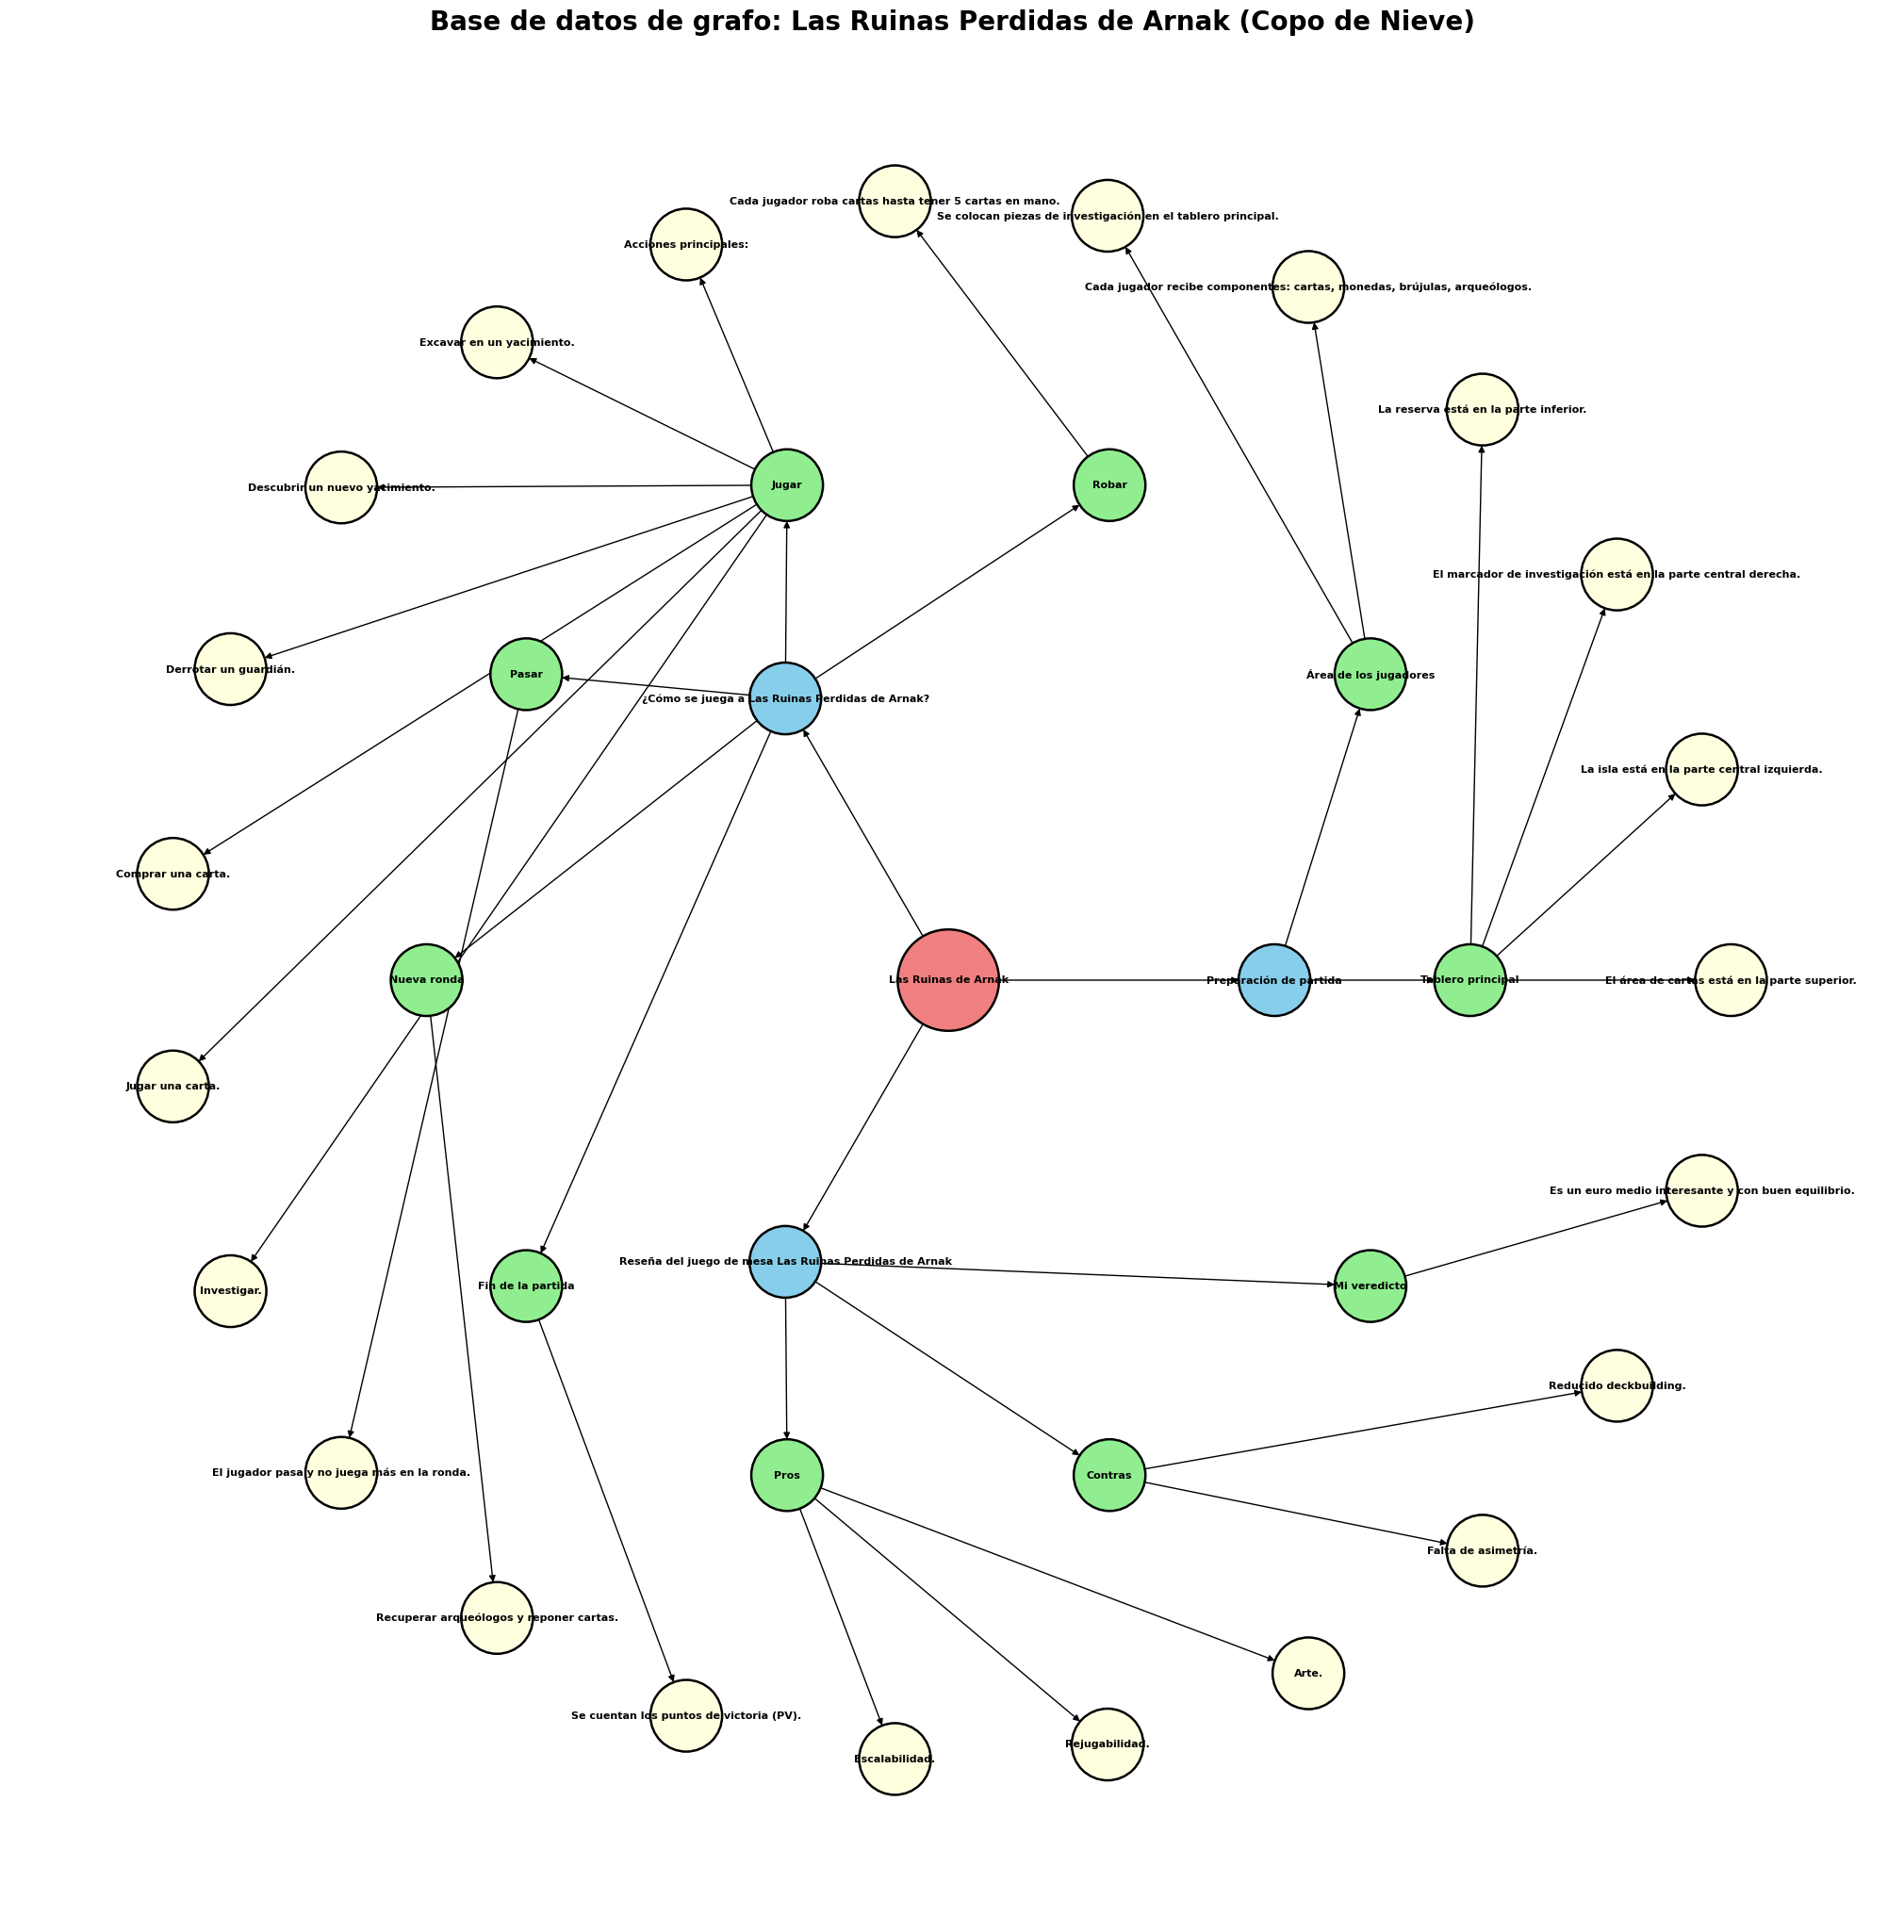

In [21]:
def leer_contenido_txt(ruta):
    with open(ruta, 'r', encoding='utf-8') as archivo:
        return archivo.read()

def extraer_secciones_y_subsecciones(contenido):
    """Extrae nodos principales y secundarios del texto estructurado."""
    secciones = {}
    subsecciones = {}

    patron_seccion = re.compile(r'^#\s*(\d+)\.\s+(.*)')
    patron_subseccion = re.compile(r'^##\s*(\d+\.\d+)\.\s+(.*)')
    patron_puntos = re.compile(r'^-\s+(.*)')

    seccion_actual = None
    subseccion_actual = None

    for linea in contenido.split('\n'):
        linea = linea.strip()
        if not linea:
            continue

        # Detectar secciones principales
        match_seccion = patron_seccion.match(linea)
        if match_seccion:
            seccion_actual = match_seccion.group(2)
            secciones[seccion_actual] = []
            subseccion_actual = None
            continue

        # Detectar subsecciones
        match_subseccion = patron_subseccion.match(linea)
        if match_subseccion and seccion_actual:
            subseccion_actual = match_subseccion.group(2)
            subsecciones[subseccion_actual] = []
            secciones[seccion_actual].append(subseccion_actual)
            continue

        # Detectar puntos dentro de subsecciones
        match_puntos = patron_puntos.match(linea)
        if match_puntos and subseccion_actual:
            subsecciones[subseccion_actual].append(match_puntos.group(1))

    return secciones, subsecciones

def extraer_atributos(contenido):
    """Extrae atributos adicionales del texto."""
    atributos = {}
    patron_atributo = re.compile(r'^##\s*0\.\d+\.\s+(.*):\s*\n-\s+(.*)')

    for linea in contenido.split('\n'):
        linea = linea.strip()
        if not linea:
            continue
        match = patron_atributo.match(linea)
        if match:
            clave, valor = match.groups()
            atributos[clave.strip()] = valor.strip()
    return atributos

def crear_nodo_central(grafo, nombre):
    grafo.add_node(nombre, tipo="juego")

def agregar_nodos_secciones(grafo, secciones, subsecciones):
    """Agrega nodos principales, secundarios y detalles al grafo."""
    for seccion, subs in secciones.items():
        grafo.add_node(seccion, tipo="principal")
        grafo.add_edge("Las Ruinas de Arnak", seccion)
        for sub in subs:
            grafo.add_node(sub, tipo="secundario")
            grafo.add_edge(seccion, sub)
            for punto in subsecciones.get(sub, []):
                grafo.add_node(punto, tipo="detalle")
                grafo.add_edge(sub, punto)

def agregar_atributos(grafo, atributos):
    for atributo, valor in atributos.items():
        grafo.add_node(atributo, valor=valor, tipo="atributo")
        grafo.add_edge("Las Ruinas de Arnak", atributo)

def generar_posicion_copo_de_nieve(grafo):
    """Crea una disposición en forma de copo de nieve: nodos jerárquicos en círculos concéntricos."""
    pos = {}
    nodo_central = "Las Ruinas de Arnak"
    pos[nodo_central] = (0, 0)  # Nodo central en el origen

    # Nodos primarios (1er círculo)
    primarios = [n for n, d in grafo.nodes(data=True) if d.get('tipo') == "principal"]
    for i, nodo in enumerate(primarios):
        angle = 2 * math.pi * i / len(primarios)
        pos[nodo] = (math.cos(angle) * 5, math.sin(angle) * 5)  # Distancia 5 del centro

    # Nodos secundarios (2do círculo)
    secundarios = [n for n, d in grafo.nodes(data=True) if d.get('tipo') == "secundario"]
    for i, nodo in enumerate(secundarios):
        angle = 2 * math.pi * i / len(secundarios)
        pos[nodo] = (math.cos(angle) * 8, math.sin(angle) * 8)  # Distancia 8 del centro

    # Nodos detalles (3er círculo)
    detalles = [n for n, d in grafo.nodes(data=True) if d.get('tipo') == "detalle"]
    for i, nodo in enumerate(detalles):
        angle = 2 * math.pi * i / len(detalles)
        pos[nodo] = (math.cos(angle) * 12, math.sin(angle) * 12)  # Distancia 12 del centro

    return pos

def visualizar_grafo_copo_de_nieve(grafo):
    plt.figure(figsize=(20, 20))
    pos = generar_posicion_copo_de_nieve(grafo)

    # Configurar colores por tipo de nodo
    colores = []
    for node in grafo.nodes(data=True):
        tipo = node[1].get('tipo', '')
        if tipo == "juego":
            colores.append("lightcoral")
        elif tipo == "principal":
            colores.append("skyblue")
        elif tipo == "secundario":
            colores.append("lightgreen")
        elif tipo == "detalle":
            colores.append("lightyellow")
        elif tipo == "atributo":
            colores.append("gold")
        else:
            colores.append("lightgray")

    # Ajustar tamaño de los nodos
    tamanos_nodos = [6000 if node[1].get('tipo') == 'juego' else 3000 for node in grafo.nodes(data=True)]

    # Dibujar el grafo con colores y bordes
    nx.draw(
        grafo, pos, with_labels=True, node_size=tamanos_nodos, node_color=colores, font_size=8, font_weight="bold",
        edgecolors='black', linewidths=1.8
    )

    plt.title("Base de datos de grafo: Las Ruinas Perdidas de Arnak (Copo de Nieve)", fontsize=20, fontweight="bold")
    plt.show()

def main():
    ruta_txt = "arnak.txt"  # Asegúrate de tener este archivo cargado
    contenido = leer_contenido_txt(ruta_txt)

    # Extraer secciones, subsecciones y atributos
    secciones, subsecciones = extraer_secciones_y_subsecciones(contenido)
    atributos = extraer_atributos(contenido)

    graph = nx.DiGraph()

    # Nodo central
    crear_nodo_central(graph, "Las Ruinas de Arnak")

    # Agregar secciones y atributos al grafo
    agregar_nodos_secciones(graph, secciones, subsecciones)
    agregar_atributos(graph, atributos)

    # Visualizar el grafo
    visualizar_grafo_copo_de_nieve(graph)

if __name__ == "__main__":
    main()


## Base de datos tabular

In [22]:
def fetch_versions_data():
    url = "https://boardgamegeek.com/xmlapi2/thing?id=312484&versions=1"
    response = requests.get(url)
    response.raise_for_status()

    root = ET.fromstring(response.text)
    results = []

    for version_item in root.findall(".//item[@type='boardgameversion']"):
        data = {
            "Board Game": "Lost Ruins of Arnak",
            "Name": "",
            "Version Publisher": "",
            "Version Artist": "",
            "Year Released": "",
            "Dimensions": "",
            "Weight": "",
            "Languages": ""
        }

        # Nombre de la edición
        name_element = version_item.find(".//name[@type='primary']")
        if name_element is not None:
            data["Name"] = name_element.get("value", "")

        # Año de publicación
        year_element = version_item.find("yearpublished")
        if year_element is not None:
            data["Year Released"] = year_element.get("value", "")

        # Publicadores
        publishers = version_item.findall(".//link[@type='boardgamepublisher']")
        if publishers:
            pub_names = [p.get("value", "") for p in publishers]
            data["Version Publisher"] = ", ".join(pub_names)

        # Artistas
        artists = version_item.findall(".//link[@type='boardgameartist']")
        if artists:
            artist_names = [a.get("value", "") for a in artists]
            data["Version Artist"] = ", ".join(artist_names)

        # Idiomas
        languages = version_item.findall(".//link[@type='language']")
        if languages:
            lang_names = [l.get("value", "") for l in languages]
            data["Languages"] = ", ".join(lang_names)

        # Dimensiones y peso
        width_element = version_item.find("width")
        length_element = version_item.find("length")
        depth_element = version_item.find("depth")
        weight_element = version_item.find("weight")

        width = width_element.get("value", "") if width_element is not None else ""
        length = length_element.get("value", "") if length_element is not None else ""
        depth = depth_element.get("value", "") if depth_element is not None else ""

        # Construir Dimensions si todos están presentes
        if width and length and depth:
            data["Dimensions"] = f"{width} x {length} x {depth}"

        # Peso
        if weight_element is not None:
            data["Weight"] = weight_element.get("value", "")

        # Version Nickname y Alternate Nickname no están en el XML, se dejan vacías

        results.append(data)

    return results

if __name__ == "__main__":
    results = fetch_versions_data()

    # Crear el DataFrame a partir de los resultados
    df = pd.DataFrame(results)

    # Guardar los datos en un archivo CSV
    df.to_csv("boardgame_versions_data.csv", index=False)

df.head()

,Board Game,Name,Version Publisher,Version Artist,Year Released,Dimensions,Weight,Languages
0,Lost Ruins of Arnak,Bulgarian edition,"Czech Games Edition, Fantasmagoria","Ondřej Hrdina, Jiří Kůs, Jakub Politzer, Frant...",2021,10.0394 x 14.3701 x 2.75591,5.2448,Bulgarian
1,Lost Ruins of Arnak,Chinese edition,"Czech Games Edition, More Fun Co., Ltd., One M...",,2022,10.0394 x 14.5669 x 2.95276,0,Chinese
2,Lost Ruins of Arnak,Czech edition,"Czech Games Edition, MINDOK","Ondřej Hrdina, Jiří Kůs, Jakub Politzer, Frant...",2020,10.1575 x 14.4882 x 2.91339,4.74876,Czech
3,Lost Ruins of Arnak,Danish edition,"Czech Games Edition, Spilbræt.dk",,2022,10.2362 x 14.5669 x 2.95276,0,Danish
4,Lost Ruins of Arnak,Dutch edition,White Goblin Games,"Ondřej Hrdina, Jiří Kůs, Jakub Politzer, Frant...",2021,10.0394 x 14.5669 x 2.95276,0,Dutch


# RAG